# AdaBoost

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv
import Orange
from Orange.preprocess import Continuize
from Orange.classification import Learner, Model
%matplotlib inline

## Podatki

Pripravimo take podatke, za katere tehnika učenja, ki jo bomo uporabili, prav gotovo ne more prepoznati primerne odločitvene meje. Uporabili bomo klasifikacijska drevesa globine 1 (torej, koren ki mu sledijo listi). Pri podatkih z dvemi atributi tako drevo lahko razdeli primere samo z eno horizontalno in vertikalno premico. Torej prav gotovo ne bo mogel dobro prepoznati primerov z razredi, kjer je odločitvena meja krog.

In [2]:
np.random.seed(42)
X = (np.random.rand(500, 2)-0.5) * 20
y = (np.sqrt(np.sum(X**2, axis=1)) > 8).astype(int)
circle = Orange.data.Table(X, y)

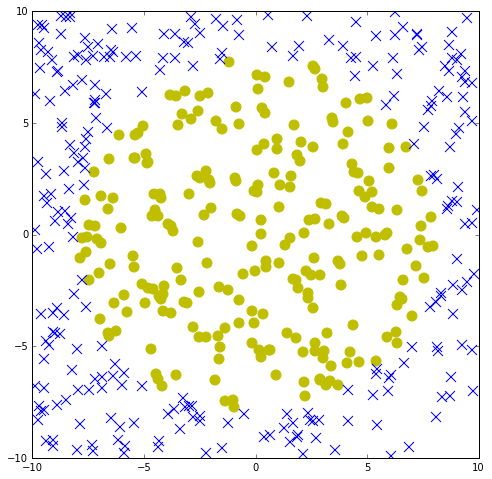

In [3]:
colors = ["y", "b"]
markers = ["o", "x"]
plt.figure(figsize=(8, 8))
for c in [0, 1]:
    plt.scatter(X[:, 0][y==c], X[:, 1][y==c], marker=markers[c], color=colors[c], s=100)
plt.axis("equal");
plt.xlim([-10, 10])
plt.ylim([-10, 10]);

Zgradimo sedaj naš model in prikažimo, kako dobro razvrsti naše podatke. Model, še enkrat, je klasifikacijsko drevo globine 1. Potem prikažimo podatke tako, da izrišemo samo te, ki so napačno klasificirani. Za ponazoritev odločitvene meje bomo v ozadju s sivimi točkami prikazali te, kjer je model napovedal prvi (debelejše sive pike) ali drugi (pikice) razred.

In [4]:
tree = Orange.classification.SimpleTreeLearner(max_depth=1)
model = tree(circle)

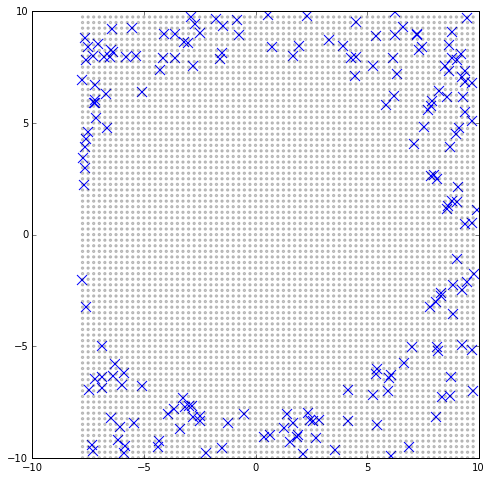

In [5]:
G = np.array([(x, y) for x in np.arange(-10, 10, .25) for y in np.arange(-10, 10, .25)])
y_grid = model(G, True)
y_hat = model(X)

plt.figure(figsize=(8, 8))
for c in [0, 1]:
   plt.scatter(X[:, 0][(y!=y_hat) & (y==c)], X[:, 1][(y!=y_hat) & (y==c)], 
               marker=markers[c], color=colors[c], s=100)
plt.scatter(G[:, 0], G[:, 1], s=y_grid[:, 0]*10, color="k", alpha=0.2)
plt.axis("equal");
plt.xlim([-10, 10])
plt.ylim([-10, 10]);

Odločitvena meja je torej premica. Drevo pravilno klasificira večino (ali pa vse) primere na eni strani premice (na zgornji sliki je to levo od odločitvene ravnine), na drugi strani premice (na desni strani odločitvene ravnine) pa so vsi primeri enega od razredov napačno klasificirani (vsi modri križci).

## Orange-ov razred za AdaBoost

Razreda za učenje in klasifikacijo po metodi AdaBoost izvedemo iz klasifikacijskih Learner (za učenje) in Model (za napovedovanje). Learner bo kot parametre zahteval osnovni učni algoritem in (opcijsko) največje število modelov, ki jih naj zgradi in ki bodo tvori ansambel.

In [6]:
class AdaBoostLearner(Learner):
    """Adaptive Boosting."""
    def __init__(self, learner, n_estimators=10):
        super().__init__()
        self.n_estimators = n_estimators  # number of bootstrap samples and corresponding models
        self.learner = learner  # base learner
        self.name = "adaboosted " + self.learner.name
        
    def fit_storage(self, data):
        """Return a adaboosted model inferred from the training set."""
        errors = []
        models = []
        weights = []
        w = np.ones(len(data)) / len(data)
        for i in range(self.n_estimators):
            ids = np.random.choice(np.arange(len(data)), len(data), p=w)
            sample = data[ids]
            model = self.learner(sample)
            y_hat = model(data)
            err = np.sum(w[y_hat != data.Y]) / np.sum(w)
            if (err == 0) or (err > 0.5):
                break
            beta = err / (1 - err)
            w[y_hat == data.Y] *=  beta
            w = w / np.sum(w)

            models.append(model)
            errors.append(err)
            weights.append(np.copy(w))
            
        model = AdaBoostModel(models, np.array(errors), weights)
        return model

class AdaBoostModel(Model):
    """Classifier from adaboosted learner."""
    def __init__(self, models, errors, weights):
        self.models = models  # a list of predictors
        self.m_weight = np.log(1/errors)
        self.weights = weights
    
    def predict(self, X, ret=Orange.classification.Model.Value):
        """Given a data instance or table of data instances returns predicted class."""
        ps = np.zeros((2, X.shape[0]))
        for m, w in zip(self.models, self.m_weight):
            y_hat = m(X)  #vector of 0's and 1's
            p = np.vstack(((1-y_hat)*w, y_hat*w))
            ps += p
        return (ps[0] < ps[1]).astype(int)

## Testiranje

Razred za AdaBoost dajmo sedaj uporabiti. Pred samim prečnim preverjanjem tipično dobro preverimo, ali vse deluje tako, kot bi pričakovali. Zgradimo zato en model in preverimo, ali so rezultati vsaj sintaktično pravilni (ter seveda, ali lahko sploh poženemo naš razred tako, da se koda kje ne zruši).

In [7]:
tree = Orange.classification.SimpleTreeLearner(max_depth=1)
ab_tree = AdaBoostLearner(tree, 10)
model = ab_tree(circle)
model(circle[:3], 1)

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]])

Sledi koda za prevečno preverjanje in dejanski test. Pričakujemo na primer, da bo AdaBoost klasifikacijskih dreves bolj natančen kot eno drevo samo. Tokrat gradimo model z AdaBoost-om tako, da uporabimo sto dreves

In [8]:
ab_tree = AdaBoostLearner(tree, 100)
maj = Orange.classification.MajorityLearner()
res = Orange.evaluation.CrossValidation(circle, [maj, tree, ab_tree], k=5)
Orange.evaluation.CA(res)

array([ 0.514,  0.612,  0.89 ])

Huh, dela! Eno samo klasifikacijsko drevo ima precej mizerno točnost, pri sto drevesih zgrajenih z AdaBoost pa je točnost kar zavidljiva. Bi pa se splačalo preveriti in primerjati točnost še s kakšno drugo metodo (recimo z naključnimi gozdovi).

Zadevo bi bilo dobro ponazoriti tudi grafično. Pri gradnji modelov smo namenoma, pri vsakem od modelu, pomnili uteži primerov. Teh uteži sicer pri klasifikaciji ne rabimo (potrebujemo samo utež modela), a smo jih pomnili zato, da jih lahko izrišemo. To naredimo spodaj. Na sliki izrišemo odločitveno mejo z i-ti model, ter uteži primerov, ki jih je ta model uporabil.

In [9]:
ab_tree = AdaBoostLearner(tree, 100)
model = ab_tree(circle)

In [10]:
len(model.models)

71

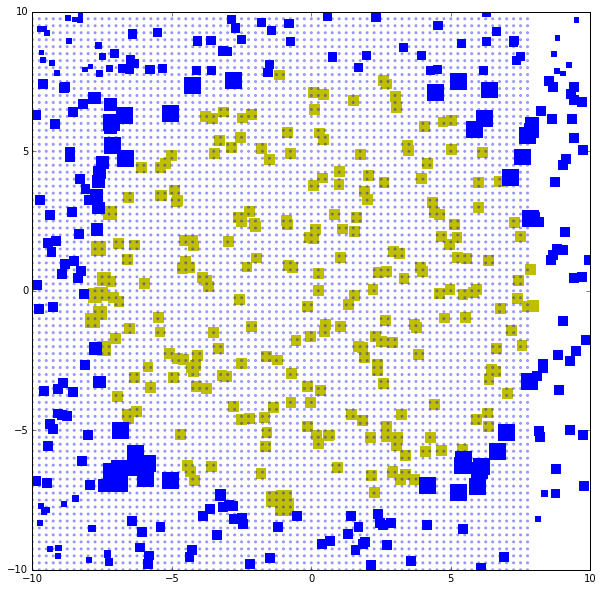

In [11]:
i = 20
G = np.array([(x, y) for x in np.arange(-10, 10, .25) for y in np.arange(-10, 10, .25)])
y_hat = model.models[i](G, True)

yy = model.models[i](X)

plt.figure(figsize=(10,10))
for c in [0, 1]:
   plt.scatter(X[:, 0][y==c], X[:, 1][y==c], marker="s", color=colors[c], alpha=1, s=model.weights[i][y==c]*len(X)*100)
#   plt.scatter(X[:, 0][(y==yy) & (y==c)], X[:, 1][(y==yy) & (y==c)], marker="s", color=colors[c], alpha=1)
plt.scatter(G[:, 0], G[:, 1], s=y_hat[:, 0]*10, color=colors[c], alpha=0.3)
plt.axis("equal");
plt.xlim([-10, 10])
plt.ylim([-10, 10]);

Zgornje nas ne bi smelo presenetiti. Pri enaindvajstem modelu (i=20) so težavni primeri, torej tisti, z večjo utežjo, v kotih kvadrata, ki občrta krog, ki razmejuje primeri različnih razredov.

Zanimivo je izrisati še, kje poteka odločitvena meja v modelu, ki ga je naredil AdaBoost. Spodaj.

In [12]:
ab_tree = AdaBoostLearner(tree, 1000)
model = ab_tree(circle)
len(model.models)

46

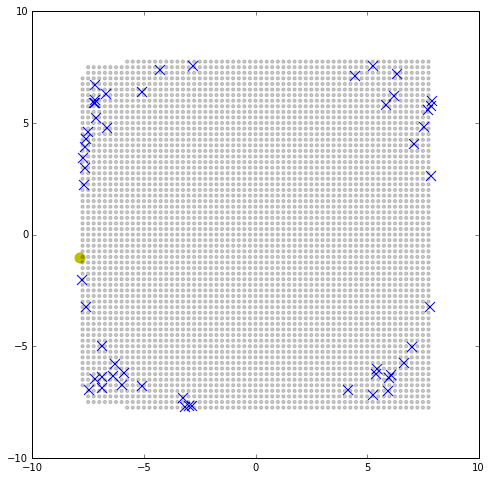

In [13]:
G = np.array([(x, y) for x in np.arange(-10, 10, .25) for y in np.arange(-10, 10, .25)])
y_grid = model(G, True)
y_hat = model(X)

plt.figure(figsize=(8, 8))
for c in [0, 1]:
   plt.scatter(X[:, 0][(y!=y_hat) & (y==c)], X[:, 1][(y!=y_hat) & (y==c)], 
               marker=markers[c], color=colors[c], s=100)
plt.scatter(G[:, 0], G[:, 1], s=y_grid[:, 0]*10, color="k", alpha=0.2)
plt.axis("equal");
plt.xlim([-10, 10])
plt.ylim([-10, 10]);

Meja je nekako škatlasta krožnica, kot smo pričakovali. Primerov v učni množici, ki jih tak model razvrsti napačno, je sicer nekaj, a vsekakor manj kot teh, ki bi jih napačno razvrstilo kakšno plitvo klasifikacijsko drevo.